# Window function and amplitude correction

In [1]:
from radiocalibrationtoolkit import *
from scipy.signal import butter, lfilter
from scipy.signal import blackmanharris, boxcar, hann

[INFO] LFmap: Import successful.


In [2]:
# some global plot settings
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["font.weight"] = "bold"
plt.rcParams["font.size"] = 16
plt.rcParams["legend.fontsize"] = 12

plt.rcParams["xtick.major.width"] = 2
plt.rcParams["ytick.major.width"] = 2

plt.rcParams["xtick.major.size"] = 5
plt.rcParams["ytick.major.size"] = 5

plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14

## Examine effects on a single trace

In [3]:
N = 2048   # samples
fs_Hz = 250e6 # sampling frequency
signal_freq_Hz = 55.5e6 # signal
win = blackmanharris(N) # window function type

In [4]:
tx = np.arange(N) / fs_Hz
def make_simple_time_trace(signal_amplitude=0.7, signal_frequency=55.5e+6, noise_amplitude=1, N=2048, apply_filter=True):
    time_trace = signal_amplitude * np.sin(2*np.pi*signal_frequency*tx) + noise_amplitude * np.random.normal(size=N)
    b, a = butter(5, [30e6, 80e6], fs=250e6, btype='band')
    if apply_filter:
        time_trace = lfilter(b, a, time_trace)
    return np.round(time_trace * N) / N

Text(0, 0.5, 'amplitude [ADC]')

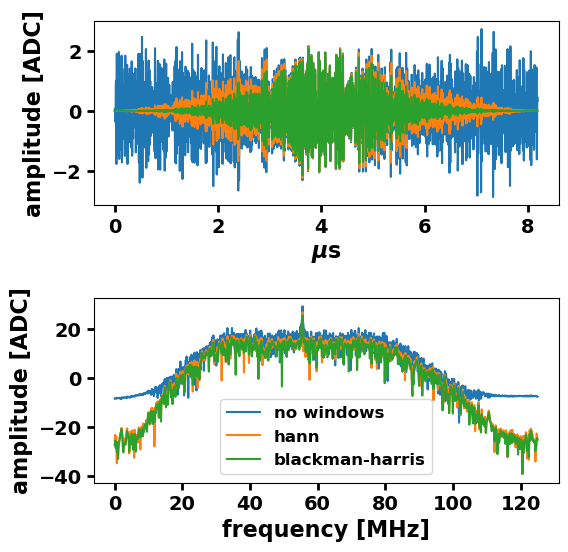

In [5]:
tt = make_simple_time_trace(signal_amplitude=1)
fx = np.fft.rfftfreq(N, 1/fs_Hz)*1e-6

fig, ax = plt.subplots(2,1, figsize=(6,6))
labels = ['no windows', 'hann', 'blackman-harris']
for i, w in enumerate([1, hann(N), blackmanharris(N)]):
    ax[0].plot(tx*1e+6, tt*w)
    ax[1].plot(fx, 10*np.log10(np.abs(np.fft.rfft(tt*w))), label=labels[i])

fig.subplots_adjust(hspace=0.5)
ax[1].legend()

ax[0].set_xlabel("$\mu$s")
ax[1].set_xlabel("frequency [MHz]")
ax[0].set_ylabel("amplitude [ADC]")
ax[1].set_ylabel("amplitude [ADC]")


In [6]:
# generate time trace
time_trace = make_simple_time_trace()

# calculate two sided spectrum
spectrum = np.abs(fft(time_trace))
# calculate one sided spectrum (not corrected for the one side)
rspectrum = np.abs(np.fft.rfft(time_trace))

# calculate one sided spectrum (corrected for the one side)
r2spectrum = correct_energy_of_one_sided_spectrum(rspectrum)

# calculate amplitude window function correction
Aw = N/np.sum(win) /np.sqrt(2)

# calculate two sided spectrum using a window function (not corrected for the one side)
spectrum_w = np.abs(fft(time_trace*win))
# calculate one sided spectrum using a window function (not corrected for the one side)
rspectrum_w = np.abs(np.fft.rfft(time_trace*win))

# calculate one sided spectrum (corrected for the one side)
r2spectrum = correct_energy_of_one_sided_spectrum(rspectrum)
r2spectrum_w = correct_energy_of_one_sided_spectrum(rspectrum_w)

# define X-axis values
fx = np.fft.rfftfreq(N, 1/fs_Hz)/1e+6

In [7]:
# calculate energy from time trace, one and two sided spectrum with and without window
# when the window is used, the amplitudes are corrected
print(
    f"Energy calculated from:\n"
    f"time trace = {get_energy_from_time_trace(time_trace):.2f},\n"
    f"two sided spectrum = {get_energy_from_two_sided_spectrum(spectrum):.2f},\n"
    f"one sided spectrum = {get_energy_from_one_sided_spectrum(rspectrum):.2f},\n"
    f"windowed two sided spectrum = {get_energy_from_two_sided_spectrum(spectrum_w):.2f},\n"
    f"one sided spectrum corrected for being the one sided spectrum = {get_energy_from_one_sided_spectrum_corrected4one_side(r2spectrum):.2f},\n"
    f"windowed two sided spectrum corrected by window function loss = {get_energy_from_two_sided_spectrum(spectrum_w * Aw):.2f},\n"
    f"windowed one sided spectrum corrected by window function loss = {get_energy_from_one_sided_spectrum(rspectrum_w * Aw):.2f},\n"
    f"one sided spectrum corrected for being the one sided spectrum and for window function loss = {get_energy_from_one_sided_spectrum_corrected4one_side(r2spectrum_w*Aw):.2f},\n"
)

Energy calculated from:
time trace = 1312.02,
two sided spectrum = 1312.02,
one sided spectrum = 1312.02,
windowed two sided spectrum = 364.04,
one sided spectrum corrected for being the one sided spectrum = 1312.02,
windowed two sided spectrum corrected by window function loss = 1415.67,
windowed one sided spectrum corrected by window function loss = 1415.67,
one sided spectrum corrected for being the one sided spectrum and for window function loss = 1415.67,



### Trace with a broad band pulse

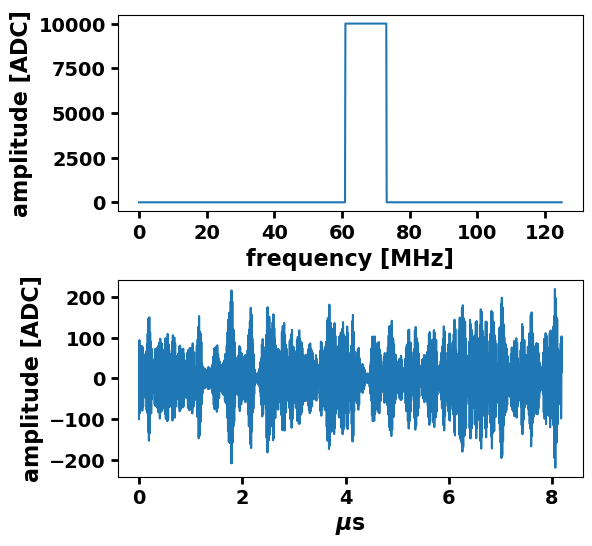

In [8]:
# create a broad band noise trace
bb_spec=np.zeros(1025)
bb_spec[500:600] = 10000


bb_tt = np.real(ifft(one_sided_2_complex_two_sided(bb_spec)))

fig, ax = plt.subplots(2,1, figsize=(6,6))

ax[0].set_xlabel("frequency [MHz]")
ax[0].set_ylabel("amplitude [ADC]")
ax[1].set_ylabel("amplitude [ADC]")
ax[1].set_xlabel("$\mu$s")

ax[0].plot(fx, bb_spec)
ax[1].plot(tx*1e+6, bb_tt)

fig.subplots_adjust(hspace=0.35)

In [9]:
# add broad band pulse to the time trace
time_trace_e = time_trace.copy()
time_trace_e[np.arange(1024, 1024+40)] = bb_tt[:40]

rspectrum_e = np.abs(np.fft.rfft(time_trace_e))
rspectrum_w_e = np.abs(np.fft.rfft(time_trace_e*win))


In [10]:
def show_plots(time_trace, show_window_func=True):
    rspectrum = np.abs(np.fft.rfft(time_trace))
    rspectrum_w = np.abs(np.fft.rfft(time_trace * win))
    Aw = N / np.sum(win) / np.sqrt(2)

    e_tt = get_energy_from_time_trace(time_trace)
    e_spec = get_energy_from_one_sided_spectrum(rspectrum)
    e_spec_w = get_energy_from_one_sided_spectrum(rspectrum_w * Aw)

    fig, ax = plt.subplots(2, 1, figsize=(6, 6))

    mu = 1e6
    ax[0].plot(
        tx * mu, time_trace, label="no window: E={:.1f} a.u.".format(e_tt), alpha=0.7
    )
    ax[0].plot(tx * mu, time_trace * win, label="windowed", alpha=0.7)
    
    if show_window_func:
        ax[0].plot(tx * mu, win * 100, label="window func. x100", alpha=1)

    ax[1].plot(
        fx , rspectrum, label="no window:         E={:.1f} a.u.".format(e_spec), alpha=0.7
    )

    ax[1].plot(
        fx ,
        rspectrum_w * Aw,
        label="windowed & A$_w$: E={:.1f} a.u.".format(e_spec_w),
        alpha=0.7,
    )

    display(
        get_energy_from_time_trace(time_trace),
        get_energy_from_one_sided_spectrum(rspectrum),
        get_energy_from_one_sided_spectrum(rspectrum_w * Aw),
    )

    ax[0].set_xlabel("$\mu$s")
    ax[1].set_xlabel("frequency [MHz]")
    ax[0].set_ylabel("amplitude [ADC]")
    ax[1].set_ylabel("amplitude [ADC]")

    ax[0].legend()
    ax[1].legend()
    
    fig.subplots_adjust(hspace=0.3)

1312.023519039154

1312.0235190391543

1415.6662206871995

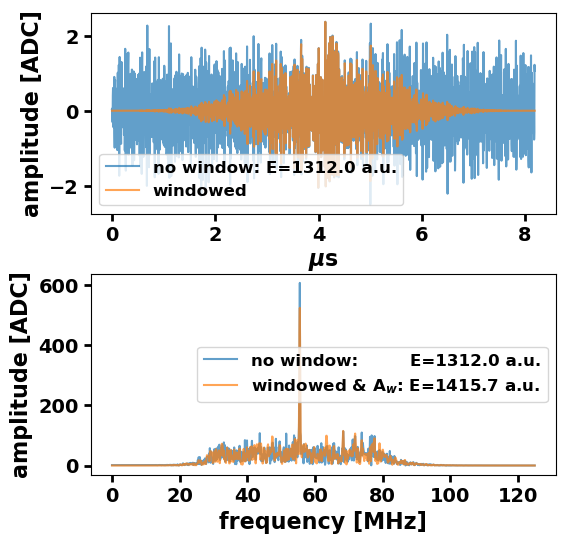

In [11]:
# trace without the broad band pulse
show_plots(time_trace, show_window_func=False)

110355.62499359486

110355.62499359484

423262.4520872715

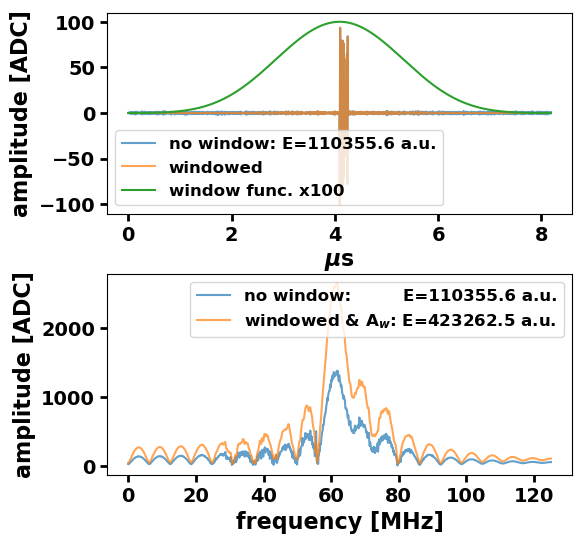

In [12]:
# trace with the broad band pulse
time_trace_e = time_trace.copy()
time_trace_e[np.arange(1024, 1024+40)] = bb_tt[:40]
show_plots(time_trace_e)

110355.62499359486

110355.62499359484

20092.099716503628

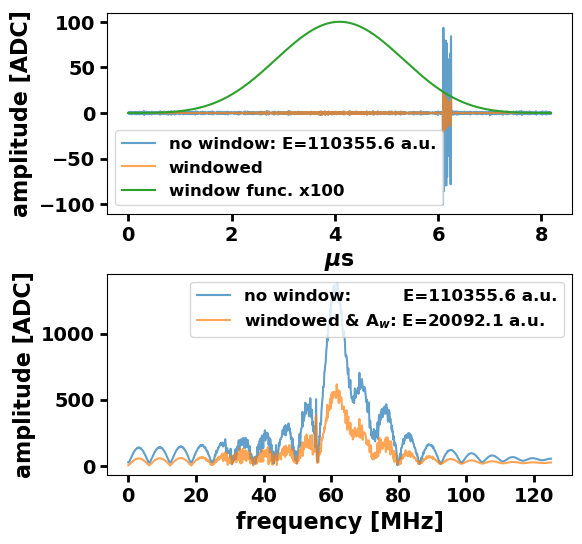

In [13]:
# rolled trace to shift the broad band pulse
show_plots(np.roll(time_trace_e, 500))

The learning here is that a amplitudes of a trace with broad band pulse cannot be safely corrected
after the window function because the window function is symmetric and the broad band pulse appearing 
in random parts of the trace will be each time differently supressed by the window function.

Note that the energy of the trace is after the rolling of the trace still the same when no window is used.

## Distributions of the energy ratios of not windowed spectra and windowed spectra with amplitude correction

In [14]:
def get_averaged_spectra_and_diffs(arr):
    diffs = np.array([])
    n, N = arr.shape
    avr_rspectrum = 0
    avr_rspectrum_w = 0
    win = blackmanharris(N)
    Aw = N / np.sum(win) / np.sqrt(2)
    for i in range(n):
        time_trace = arr[i, :]
        rspectrum = np.abs(np.fft.rfft(time_trace))
        rspectrum_w = np.abs(np.fft.rfft(time_trace * win))
        diffs = np.append(
            diffs,
            get_energy_from_time_trace(time_trace)
            / get_energy_from_one_sided_spectrum(rspectrum_w * Aw),
        )
        avr_rspectrum += rspectrum
        avr_rspectrum_w += rspectrum_w

    avr_rspectrum /= n
    avr_rspectrum_w /= n
    return avr_rspectrum, avr_rspectrum_w, diffs


def show_results(
    avr_rspectrum,
    avr_rspectrum_w,
    diffs,
    histo_edge=2,
    N=2048,
    bins=None,
    xax_min=None,
    xax_max=None,
    xlim= [None, None]
):
    fig, ax = plt.subplots()
    fx = np.fft.rfftfreq(N, 1 / fs_Hz) / 1e6

    if bins == None:
        bins = linspace_with_middle_value(
            np.mean(diffs), histo_edge * np.std(diffs), 20
        )
    ax.hist(diffs, bins=bins)
    # Calculate mean and standard deviation
    mean_diff = np.mean(diffs)
    std_diff = np.std(diffs)

    print(mean_diff)
    print(std_diff)

    # Add text box with mean and standard deviation
    text_box = f"$\mu$: {mean_diff:.2f}\n$\sigma$: {std_diff:.2f}"
    ax.text(
        0.95,
        0.95,
        text_box,
        transform=ax.transAxes,
        verticalalignment="top",
        horizontalalignment="right",
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.5),
    )

    ax.set_xlim(xax_min, xax_max)
    ax.set_xlabel(
        r"$\frac{\mathrm{energy: \ spectrum \ with \ no\ window}}{\mathrm{energy:spectrum \ with\ window,\ amplitudes\ corrected}}$"
    )
    ax.set_ylabel("entries")

    fig, ax = plt.subplots()

    ax.plot(fx, voltageAmp2dB(avr_rspectrum), alpha=0.7, label="no window")
    ax.plot(fx, voltageAmp2dB(avr_rspectrum_w), alpha=0.7, label="with window")
    ax.plot(
        fx,
        voltageAmp2dB(avr_rspectrum_w * Aw),
        alpha=0.7,
        label="with window " + "\n" + "and corrected",
    )
    
    
    # ax.axes.axvspan(30,80, color='b', alpha=0.1)
    ax.set_xlim(*xlim)
    autoscale_y(ax)     
    
    ax.set_xlabel("frequency [MHz]")
    ax.set_ylabel("dB")
    ax.legend()

### Simple traces

In [15]:
# create a set of 1000 time traces
n = 1000
avr_rspectrum = 0
avr_rspectrum_w = 0
time_traces = make_simple_time_trace()
for i in range(n-1):
    time_traces = np.vstack((time_traces, make_simple_time_trace()))

In [16]:
# calculate energy ratios of unwindowed spectra and windowed with amplitude correction
# and average spectra
avr_rspectrum, avr_rspectrum_w, diffs = get_averaged_spectra_and_diffs(time_traces)
diffs1 = diffs
label4final_histo = ['simple traces']

1.0001780862822474
0.0628384105306683


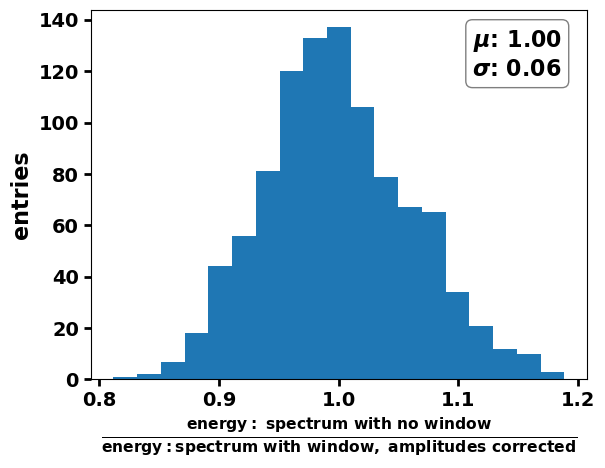

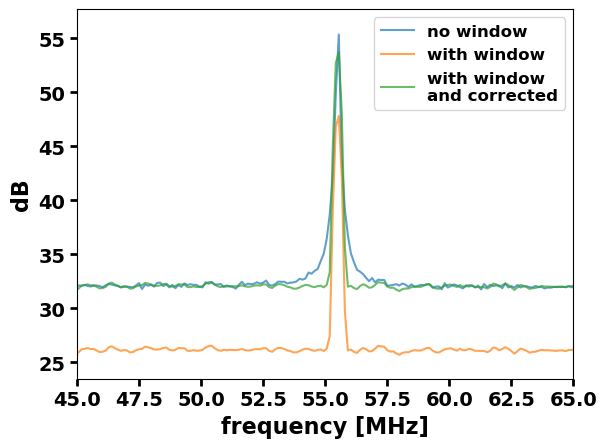

In [17]:
show_results(avr_rspectrum, avr_rspectrum_w, diffs, histo_edge=3, xlim=[45, 65])

In [18]:
# create a set of 1000 time traces with bb pulses
n = 1000
avr_rspectrum = 0
avr_rspectrum_w = 0
time_traces = make_simple_time_trace()
for i in range(n-1):
    time_trace = make_simple_time_trace()
    start_bb_index = np.random.randint(0, 2048-40)
    time_trace[np.arange(start_bb_index, start_bb_index+40)] = bb_tt[:40]
    time_traces = np.vstack((time_traces, time_trace))

In [19]:
avr_rspectrum, avr_rspectrum_w, diffs = get_averaged_spectra_and_diffs(time_traces)

27.606966171463824
34.26704617839618


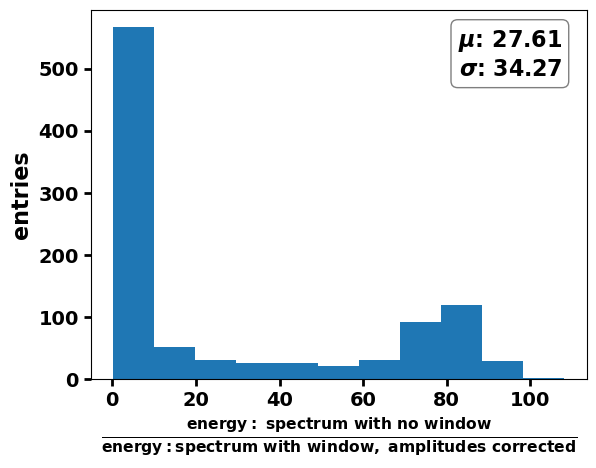

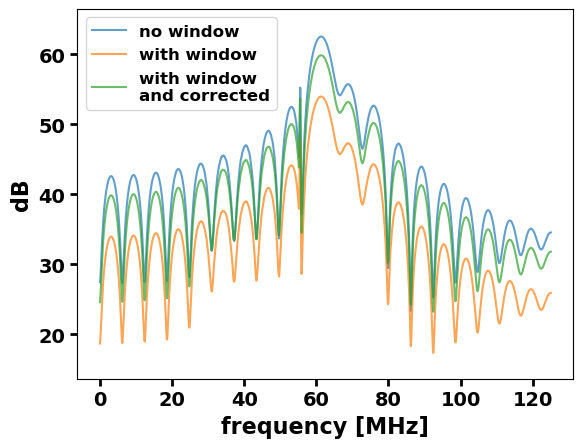

In [20]:
show_results(avr_rspectrum, avr_rspectrum_w, diffs, histo_edge=3, bins='auto')
# ,xax_min=-10, xax_max=80)

### Mock traces

In [21]:
# read HW response
hw_file_path = "./antenna_setup_files/HardwareProfileList_realistic.xml"
hw_dict = read_hw_file(hw_file_path, interp_args={"fill_value": "extrapolate"})

hw_reponse_1 = hw_dict["RResponse"]["LNA"]
hw_reponse_2 = hw_dict["RResponse"]["digitizer"]
hw_reponse_3 = hw_dict["RResponse"]["cable_fromLNA2digitizer"]
hw_reponse_4 = hw_dict["RResponse"]["impedance_matching_EW"]


# merge all hw responses to one function
def hw_response_func(x):
    return dB2PowerAmp(
        hw_reponse_1(x) + hw_reponse_2(x) + hw_reponse_3(x) + hw_reponse_4(x)
    )


# impedance function
impedance_func = hw_dict["IImpedance"][
    "antenna_EW"
]

# read sidereal voltage square spectral density
sidereal_voltage2_density_DF = pd.read_csv(
    "./voltage2_density/voltage2_density_Salla_EW_GSM16.csv",
    index_col=0,
)
sidereal_voltage2_density_DF.columns = sidereal_voltage2_density_DF.columns.astype(
    float
)

<?xml version="1.0" encoding="iso-8859-1"?>
<Element HardwareProfileList at 0x7ff137bd5e00>


In [22]:
mock_trace_generator = Mock_trace_generator(
    sidereal_voltage2_density_DF=sidereal_voltage2_density_DF,
    hw_response_func=hw_response_func,
    impedance_func=impedance_func,
    voltage2ADC=2048,
    time_trace_size=2048,
    sampling_frequency_MHz=250,
)
freq_MHz_bins = mock_trace_generator.get_frequency_bins()

In [23]:
piko = 1e-12
additional_noise = 5e-4*piko
debug_spectra_dict = mock_trace_generator.generate_mock_trace(
    1,
    lst=15,
    temp_celsius=30,
    nbi={"67.2": 1},
    nbi_err=0.2,
    return_debug_dict=True,
    additional_noise=additional_noise,
)[0]

  0%|                                                                                                         | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 321.45it/s]

In [24]:
number_of_traces = 1000
mock_traces_DF = mock_trace_generator.generate_mock_trace(
    number_of_traces,
    temp_celsius=[-10,30],
    additional_noise=additional_noise,
    nbi={"67.25": 1},
    nbi_err=0.3,
)

  0%|                                                                                                      | 0/1000 [00:00<?, ?it/s]

  0%|▍                                                                                             | 4/1000 [00:00<00:30, 32.57it/s]

  1%|▊                                                                                             | 8/1000 [00:00<00:30, 32.57it/s]

  1%|█                                                                                            | 12/1000 [00:00<00:30, 32.62it/s]

  2%|█▍                                                                                           | 16/1000 [00:00<00:30, 32.67it/s]

  2%|█▊                                                                                           | 20/1000 [00:00<00:30, 32.65it/s]

  2%|██▏                                                                                          | 24/1000 [00:00<00:29, 32.62it/s]

  3%|██▌                                                                                          | 28/1000 [00:00<00:29, 32.64it/s]

  3%|██▉                                                                                          | 32/1000 [00:00<00:29, 32.67it/s]

  4%|███▎                                                                                         | 36/1000 [00:01<00:29, 32.69it/s]

  4%|███▋                                                                                         | 40/1000 [00:01<00:29, 32.71it/s]

  4%|████                                                                                         | 44/1000 [00:01<00:33, 28.16it/s]

  5%|████▍                                                                                        | 48/1000 [00:01<00:32, 29.51it/s]

  5%|████▊                                                                                        | 52/1000 [00:01<00:31, 30.42it/s]

  6%|█████▏                                                                                       | 56/1000 [00:01<00:30, 31.12it/s]

  6%|█████▌                                                                                       | 60/1000 [00:01<00:29, 31.59it/s]

  6%|█████▉                                                                                       | 64/1000 [00:02<00:29, 31.91it/s]

  7%|██████▎                                                                                      | 68/1000 [00:02<00:28, 32.14it/s]

  7%|██████▋                                                                                      | 72/1000 [00:02<00:28, 32.34it/s]

  8%|███████                                                                                      | 76/1000 [00:02<00:28, 32.46it/s]

  8%|███████▍                                                                                     | 80/1000 [00:02<00:28, 32.51it/s]

  8%|███████▊                                                                                     | 84/1000 [00:02<00:28, 32.57it/s]

  9%|████████▏                                                                                    | 88/1000 [00:02<00:27, 32.57it/s]

  9%|████████▌                                                                                    | 92/1000 [00:02<00:27, 32.57it/s]

 10%|████████▉                                                                                    | 96/1000 [00:03<00:27, 32.53it/s]

 10%|█████████▏                                                                                  | 100/1000 [00:03<00:27, 32.49it/s]

 10%|█████████▌                                                                                  | 104/1000 [00:03<00:27, 32.51it/s]

 11%|█████████▉                                                                                  | 108/1000 [00:03<00:27, 32.53it/s]

 11%|██████████▎                                                                                 | 112/1000 [00:03<00:27, 32.55it/s]

 12%|██████████▋                                                                                 | 116/1000 [00:03<00:27, 32.50it/s]

 12%|███████████                                                                                 | 120/1000 [00:03<00:27, 32.53it/s]

 12%|███████████▍                                                                                | 124/1000 [00:03<00:26, 32.54it/s]

 13%|███████████▊                                                                                | 128/1000 [00:03<00:26, 32.47it/s]

 13%|████████████▏                                                                               | 132/1000 [00:04<00:26, 32.42it/s]

 14%|████████████▌                                                                               | 136/1000 [00:04<00:26, 32.44it/s]

 14%|████████████▉                                                                               | 140/1000 [00:04<00:26, 32.43it/s]

 14%|█████████████▏                                                                              | 144/1000 [00:04<00:26, 32.47it/s]

 15%|█████████████▌                                                                              | 148/1000 [00:04<00:26, 32.52it/s]

 15%|█████████████▉                                                                              | 152/1000 [00:04<00:26, 32.52it/s]

 16%|██████████████▎                                                                             | 156/1000 [00:04<00:25, 32.57it/s]

 16%|██████████████▋                                                                             | 160/1000 [00:04<00:25, 32.58it/s]

 16%|███████████████                                                                             | 164/1000 [00:05<00:25, 32.57it/s]

 17%|███████████████▍                                                                            | 168/1000 [00:05<00:25, 32.56it/s]

 17%|███████████████▊                                                                            | 172/1000 [00:05<00:25, 32.55it/s]

 18%|████████████████▏                                                                           | 176/1000 [00:05<00:25, 32.51it/s]

 18%|████████████████▌                                                                           | 180/1000 [00:05<00:25, 32.47it/s]

 18%|████████████████▉                                                                           | 184/1000 [00:05<00:25, 32.47it/s]

 19%|█████████████████▎                                                                          | 188/1000 [00:05<00:24, 32.49it/s]

 19%|█████████████████▋                                                                          | 192/1000 [00:05<00:24, 32.50it/s]

 20%|██████████████████                                                                          | 196/1000 [00:06<00:24, 32.49it/s]

 20%|██████████████████▍                                                                         | 200/1000 [00:06<00:24, 32.48it/s]

 20%|██████████████████▊                                                                         | 204/1000 [00:06<00:24, 32.42it/s]

 21%|███████████████████▏                                                                        | 208/1000 [00:06<00:24, 32.40it/s]

 21%|███████████████████▌                                                                        | 212/1000 [00:06<00:24, 32.41it/s]

 22%|███████████████████▊                                                                        | 216/1000 [00:06<00:24, 32.47it/s]

 22%|████████████████████▏                                                                       | 220/1000 [00:06<00:24, 32.48it/s]

 22%|████████████████████▌                                                                       | 224/1000 [00:06<00:23, 32.47it/s]

 23%|████████████████████▉                                                                       | 228/1000 [00:07<00:23, 32.48it/s]

 23%|█████████████████████▎                                                                      | 232/1000 [00:07<00:23, 32.45it/s]

 24%|█████████████████████▋                                                                      | 236/1000 [00:07<00:23, 32.42it/s]

 24%|██████████████████████                                                                      | 240/1000 [00:07<00:23, 32.15it/s]

 24%|██████████████████████▍                                                                     | 244/1000 [00:07<00:23, 32.00it/s]

 25%|██████████████████████▊                                                                     | 248/1000 [00:07<00:23, 32.05it/s]

 25%|███████████████████████▏                                                                    | 252/1000 [00:07<00:23, 32.13it/s]

 26%|███████████████████████▌                                                                    | 256/1000 [00:07<00:23, 32.21it/s]

 26%|███████████████████████▉                                                                    | 260/1000 [00:08<00:22, 32.25it/s]

 26%|████████████████████████▎                                                                   | 264/1000 [00:08<00:22, 32.29it/s]

 27%|████████████████████████▋                                                                   | 268/1000 [00:08<00:22, 32.31it/s]

 27%|█████████████████████████                                                                   | 272/1000 [00:08<00:22, 32.33it/s]

 28%|█████████████████████████▍                                                                  | 276/1000 [00:08<00:22, 32.34it/s]

 28%|█████████████████████████▊                                                                  | 280/1000 [00:08<00:22, 32.33it/s]

 28%|██████████████████████████▏                                                                 | 284/1000 [00:08<00:22, 32.34it/s]

 29%|██████████████████████████▍                                                                 | 288/1000 [00:08<00:22, 32.31it/s]

 29%|██████████████████████████▊                                                                 | 292/1000 [00:09<00:21, 32.28it/s]

 30%|███████████████████████████▏                                                                | 296/1000 [00:09<00:21, 32.27it/s]

 30%|███████████████████████████▌                                                                | 300/1000 [00:09<00:21, 32.25it/s]

 30%|███████████████████████████▉                                                                | 304/1000 [00:09<00:21, 32.26it/s]

 31%|████████████████████████████▎                                                               | 308/1000 [00:09<00:21, 32.25it/s]

 31%|████████████████████████████▋                                                               | 312/1000 [00:09<00:21, 32.28it/s]

 32%|█████████████████████████████                                                               | 316/1000 [00:09<00:21, 32.30it/s]

 32%|█████████████████████████████▍                                                              | 320/1000 [00:09<00:21, 32.34it/s]

 32%|█████████████████████████████▊                                                              | 324/1000 [00:10<00:20, 32.30it/s]

 33%|██████████████████████████████▏                                                             | 328/1000 [00:10<00:20, 32.29it/s]

 33%|██████████████████████████████▌                                                             | 332/1000 [00:10<00:20, 32.27it/s]

 34%|██████████████████████████████▉                                                             | 336/1000 [00:10<00:20, 32.25it/s]

 34%|███████████████████████████████▎                                                            | 340/1000 [00:10<00:20, 32.24it/s]

 34%|███████████████████████████████▋                                                            | 344/1000 [00:10<00:20, 32.22it/s]

 35%|████████████████████████████████                                                            | 348/1000 [00:10<00:20, 32.21it/s]

 35%|████████████████████████████████▍                                                           | 352/1000 [00:10<00:20, 32.17it/s]

 36%|████████████████████████████████▊                                                           | 356/1000 [00:11<00:20, 32.17it/s]

 36%|█████████████████████████████████                                                           | 360/1000 [00:11<00:19, 32.20it/s]

 36%|█████████████████████████████████▍                                                          | 364/1000 [00:11<00:19, 32.17it/s]

 37%|█████████████████████████████████▊                                                          | 368/1000 [00:11<00:19, 32.10it/s]

 37%|██████████████████████████████████▏                                                         | 372/1000 [00:11<00:19, 32.05it/s]

 38%|██████████████████████████████████▌                                                         | 376/1000 [00:11<00:19, 32.03it/s]

 38%|██████████████████████████████████▉                                                         | 380/1000 [00:11<00:19, 32.07it/s]

 38%|███████████████████████████████████▎                                                        | 384/1000 [00:11<00:19, 32.07it/s]

 39%|███████████████████████████████████▋                                                        | 388/1000 [00:12<00:19, 32.06it/s]

 39%|████████████████████████████████████                                                        | 392/1000 [00:12<00:18, 32.06it/s]

 40%|████████████████████████████████████▍                                                       | 396/1000 [00:12<00:18, 32.07it/s]

 40%|████████████████████████████████████▊                                                       | 400/1000 [00:12<00:18, 32.08it/s]

 40%|█████████████████████████████████████▏                                                      | 404/1000 [00:12<00:18, 32.08it/s]

 41%|█████████████████████████████████████▌                                                      | 408/1000 [00:12<00:18, 32.08it/s]

 41%|█████████████████████████████████████▉                                                      | 412/1000 [00:12<00:18, 32.08it/s]

 42%|██████████████████████████████████████▎                                                     | 416/1000 [00:12<00:18, 32.01it/s]

 42%|██████████████████████████████████████▋                                                     | 420/1000 [00:13<00:18, 32.04it/s]

 42%|███████████████████████████████████████                                                     | 424/1000 [00:13<00:18, 31.98it/s]

 43%|███████████████████████████████████████▍                                                    | 428/1000 [00:13<00:17, 32.06it/s]

 43%|███████████████████████████████████████▋                                                    | 432/1000 [00:13<00:17, 32.06it/s]

 44%|████████████████████████████████████████                                                    | 436/1000 [00:13<00:17, 32.09it/s]

 44%|████████████████████████████████████████▍                                                   | 440/1000 [00:13<00:17, 32.01it/s]

 44%|████████████████████████████████████████▊                                                   | 444/1000 [00:13<00:17, 32.03it/s]

 45%|█████████████████████████████████████████▏                                                  | 448/1000 [00:13<00:17, 32.01it/s]

 45%|█████████████████████████████████████████▌                                                  | 452/1000 [00:14<00:17, 32.06it/s]

 46%|█████████████████████████████████████████▉                                                  | 456/1000 [00:14<00:18, 29.42it/s]

 46%|██████████████████████████████████████████▏                                                 | 459/1000 [00:14<00:20, 26.91it/s]

 46%|██████████████████████████████████████████▌                                                 | 462/1000 [00:14<00:21, 25.15it/s]

 46%|██████████████████████████████████████████▊                                                 | 465/1000 [00:14<00:25, 20.91it/s]

 47%|███████████████████████████████████████████                                                 | 468/1000 [00:14<00:25, 21.01it/s]

 47%|███████████████████████████████████████████▎                                                | 471/1000 [00:14<00:25, 21.12it/s]

 47%|███████████████████████████████████████████▌                                                | 474/1000 [00:15<00:24, 21.43it/s]

 48%|███████████████████████████████████████████▉                                                | 478/1000 [00:15<00:21, 24.66it/s]

 48%|████████████████████████████████████████████▎                                               | 482/1000 [00:15<00:19, 26.88it/s]

 49%|████████████████████████████████████████████▋                                               | 486/1000 [00:15<00:18, 28.42it/s]

 49%|█████████████████████████████████████████████                                               | 490/1000 [00:15<00:17, 29.51it/s]

 49%|█████████████████████████████████████████████▍                                              | 494/1000 [00:15<00:16, 30.28it/s]

 50%|█████████████████████████████████████████████▊                                              | 498/1000 [00:15<00:16, 30.81it/s]

 50%|██████████████████████████████████████████████▏                                             | 502/1000 [00:15<00:15, 31.15it/s]

 51%|██████████████████████████████████████████████▌                                             | 506/1000 [00:16<00:15, 31.40it/s]

 51%|██████████████████████████████████████████████▉                                             | 510/1000 [00:16<00:15, 31.58it/s]

 51%|███████████████████████████████████████████████▎                                            | 514/1000 [00:16<00:15, 31.67it/s]

 52%|███████████████████████████████████████████████▋                                            | 518/1000 [00:16<00:15, 31.74it/s]

 52%|████████████████████████████████████████████████                                            | 522/1000 [00:16<00:15, 31.81it/s]

 53%|████████████████████████████████████████████████▍                                           | 526/1000 [00:16<00:14, 31.85it/s]

 53%|████████████████████████████████████████████████▊                                           | 530/1000 [00:16<00:14, 31.86it/s]

 53%|█████████████████████████████████████████████████▏                                          | 534/1000 [00:16<00:14, 31.85it/s]

 54%|█████████████████████████████████████████████████▍                                          | 538/1000 [00:17<00:14, 31.87it/s]

 54%|█████████████████████████████████████████████████▊                                          | 542/1000 [00:17<00:14, 31.88it/s]

 55%|██████████████████████████████████████████████████▏                                         | 546/1000 [00:17<00:14, 31.88it/s]

 55%|██████████████████████████████████████████████████▌                                         | 550/1000 [00:17<00:14, 31.86it/s]

 55%|██████████████████████████████████████████████████▉                                         | 554/1000 [00:17<00:14, 31.85it/s]

 56%|███████████████████████████████████████████████████▎                                        | 558/1000 [00:17<00:13, 31.86it/s]

 56%|███████████████████████████████████████████████████▋                                        | 562/1000 [00:17<00:13, 31.86it/s]

 57%|████████████████████████████████████████████████████                                        | 566/1000 [00:17<00:13, 31.89it/s]

 57%|████████████████████████████████████████████████████▍                                       | 570/1000 [00:18<00:13, 31.92it/s]

 57%|████████████████████████████████████████████████████▊                                       | 574/1000 [00:18<00:13, 31.90it/s]

 58%|█████████████████████████████████████████████████████▏                                      | 578/1000 [00:18<00:13, 31.94it/s]

 58%|█████████████████████████████████████████████████████▌                                      | 582/1000 [00:18<00:13, 31.88it/s]

 59%|█████████████████████████████████████████████████████▉                                      | 586/1000 [00:18<00:12, 31.88it/s]

 59%|██████████████████████████████████████████████████████▎                                     | 590/1000 [00:18<00:12, 31.85it/s]

 59%|██████████████████████████████████████████████████████▋                                     | 594/1000 [00:18<00:12, 31.82it/s]

 60%|███████████████████████████████████████████████████████                                     | 598/1000 [00:18<00:12, 31.78it/s]

 60%|███████████████████████████████████████████████████████▍                                    | 602/1000 [00:19<00:12, 31.80it/s]

 61%|███████████████████████████████████████████████████████▊                                    | 606/1000 [00:19<00:12, 31.81it/s]

 61%|████████████████████████████████████████████████████████                                    | 610/1000 [00:19<00:12, 31.83it/s]

 61%|████████████████████████████████████████████████████████▍                                   | 614/1000 [00:19<00:12, 31.84it/s]

 62%|████████████████████████████████████████████████████████▊                                   | 618/1000 [00:19<00:11, 31.85it/s]

 62%|█████████████████████████████████████████████████████████▏                                  | 622/1000 [00:19<00:11, 31.82it/s]

 63%|█████████████████████████████████████████████████████████▌                                  | 626/1000 [00:19<00:11, 31.81it/s]

 63%|█████████████████████████████████████████████████████████▉                                  | 630/1000 [00:19<00:11, 31.74it/s]

 63%|██████████████████████████████████████████████████████████▎                                 | 634/1000 [00:20<00:11, 31.73it/s]

 64%|██████████████████████████████████████████████████████████▋                                 | 638/1000 [00:20<00:11, 31.70it/s]

 64%|███████████████████████████████████████████████████████████                                 | 642/1000 [00:20<00:11, 31.75it/s]

 65%|███████████████████████████████████████████████████████████▍                                | 646/1000 [00:20<00:11, 31.78it/s]

 65%|███████████████████████████████████████████████████████████▊                                | 650/1000 [00:20<00:11, 31.75it/s]

 65%|████████████████████████████████████████████████████████████▏                               | 654/1000 [00:20<00:10, 31.73it/s]

 66%|████████████████████████████████████████████████████████████▌                               | 658/1000 [00:20<00:10, 31.73it/s]

 66%|████████████████████████████████████████████████████████████▉                               | 662/1000 [00:20<00:10, 31.70it/s]

 67%|█████████████████████████████████████████████████████████████▎                              | 666/1000 [00:21<00:10, 31.71it/s]

 67%|█████████████████████████████████████████████████████████████▋                              | 670/1000 [00:21<00:10, 31.69it/s]

 67%|██████████████████████████████████████████████████████████████                              | 674/1000 [00:21<00:10, 31.68it/s]

 68%|██████████████████████████████████████████████████████████████▍                             | 678/1000 [00:21<00:11, 28.18it/s]

 68%|██████████████████████████████████████████████████████████████▋                             | 682/1000 [00:21<00:10, 29.08it/s]

 69%|███████████████████████████████████████████████████████████████                             | 686/1000 [00:21<00:10, 29.79it/s]

 69%|███████████████████████████████████████████████████████████████▍                            | 690/1000 [00:21<00:10, 30.32it/s]

 69%|███████████████████████████████████████████████████████████████▊                            | 694/1000 [00:22<00:09, 30.70it/s]

 70%|████████████████████████████████████████████████████████████████▏                           | 698/1000 [00:22<00:09, 30.94it/s]

 70%|████████████████████████████████████████████████████████████████▌                           | 702/1000 [00:22<00:09, 31.09it/s]

 71%|████████████████████████████████████████████████████████████████▉                           | 706/1000 [00:22<00:09, 31.22it/s]

 71%|█████████████████████████████████████████████████████████████████▎                          | 710/1000 [00:22<00:09, 31.32it/s]

 71%|█████████████████████████████████████████████████████████████████▋                          | 714/1000 [00:22<00:09, 31.36it/s]

 72%|██████████████████████████████████████████████████████████████████                          | 718/1000 [00:22<00:08, 31.39it/s]

 72%|██████████████████████████████████████████████████████████████████▍                         | 722/1000 [00:22<00:08, 31.44it/s]

 73%|██████████████████████████████████████████████████████████████████▊                         | 726/1000 [00:23<00:08, 31.41it/s]

 73%|███████████████████████████████████████████████████████████████████▏                        | 730/1000 [00:23<00:08, 31.34it/s]

 73%|███████████████████████████████████████████████████████████████████▌                        | 734/1000 [00:23<00:08, 31.36it/s]

 74%|███████████████████████████████████████████████████████████████████▉                        | 738/1000 [00:23<00:08, 31.34it/s]

 74%|████████████████████████████████████████████████████████████████████▎                       | 742/1000 [00:23<00:08, 31.31it/s]

 75%|████████████████████████████████████████████████████████████████████▋                       | 746/1000 [00:23<00:08, 31.39it/s]

 75%|█████████████████████████████████████████████████████████████████████                       | 750/1000 [00:23<00:07, 31.44it/s]

 75%|█████████████████████████████████████████████████████████████████████▎                      | 754/1000 [00:23<00:07, 31.46it/s]

 76%|█████████████████████████████████████████████████████████████████████▋                      | 758/1000 [00:24<00:07, 31.45it/s]

 76%|██████████████████████████████████████████████████████████████████████                      | 762/1000 [00:24<00:07, 31.47it/s]

 77%|██████████████████████████████████████████████████████████████████████▍                     | 766/1000 [00:24<00:07, 31.45it/s]

 77%|██████████████████████████████████████████████████████████████████████▊                     | 770/1000 [00:24<00:07, 31.38it/s]

 77%|███████████████████████████████████████████████████████████████████████▏                    | 774/1000 [00:24<00:07, 31.41it/s]

 78%|███████████████████████████████████████████████████████████████████████▌                    | 778/1000 [00:24<00:07, 31.45it/s]

 78%|███████████████████████████████████████████████████████████████████████▉                    | 782/1000 [00:24<00:06, 31.44it/s]

 79%|████████████████████████████████████████████████████████████████████████▎                   | 786/1000 [00:24<00:06, 31.43it/s]

 79%|████████████████████████████████████████████████████████████████████████▋                   | 790/1000 [00:25<00:06, 31.41it/s]

 79%|█████████████████████████████████████████████████████████████████████████                   | 794/1000 [00:25<00:06, 31.40it/s]

 80%|█████████████████████████████████████████████████████████████████████████▍                  | 798/1000 [00:25<00:06, 31.41it/s]

 80%|█████████████████████████████████████████████████████████████████████████▊                  | 802/1000 [00:25<00:06, 31.41it/s]

 81%|██████████████████████████████████████████████████████████████████████████▏                 | 806/1000 [00:25<00:06, 31.42it/s]

 81%|██████████████████████████████████████████████████████████████████████████▌                 | 810/1000 [00:25<00:06, 31.45it/s]

 81%|██████████████████████████████████████████████████████████████████████████▉                 | 814/1000 [00:25<00:05, 31.45it/s]

 82%|███████████████████████████████████████████████████████████████████████████▎                | 818/1000 [00:26<00:06, 28.01it/s]

 82%|███████████████████████████████████████████████████████████████████████████▌                | 822/1000 [00:26<00:06, 28.95it/s]

 83%|███████████████████████████████████████████████████████████████████████████▉                | 826/1000 [00:26<00:05, 29.66it/s]

 83%|████████████████████████████████████████████████████████████████████████████▎               | 830/1000 [00:26<00:05, 30.14it/s]

 83%|████████████████████████████████████████████████████████████████████████████▋               | 834/1000 [00:26<00:05, 30.52it/s]

 84%|█████████████████████████████████████████████████████████████████████████████               | 838/1000 [00:26<00:05, 30.77it/s]

 84%|█████████████████████████████████████████████████████████████████████████████▍              | 842/1000 [00:26<00:05, 30.97it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▊              | 846/1000 [00:26<00:04, 31.10it/s]

 85%|██████████████████████████████████████████████████████████████████████████████▏             | 850/1000 [00:27<00:04, 31.20it/s]

 85%|██████████████████████████████████████████████████████████████████████████████▌             | 854/1000 [00:27<00:04, 31.26it/s]

 86%|██████████████████████████████████████████████████████████████████████████████▉             | 858/1000 [00:27<00:04, 31.31it/s]

 86%|███████████████████████████████████████████████████████████████████████████████▎            | 862/1000 [00:27<00:04, 31.31it/s]

 87%|███████████████████████████████████████████████████████████████████████████████▋            | 866/1000 [00:27<00:04, 31.33it/s]

 87%|████████████████████████████████████████████████████████████████████████████████            | 870/1000 [00:27<00:04, 31.36it/s]

 87%|████████████████████████████████████████████████████████████████████████████████▍           | 874/1000 [00:27<00:04, 31.38it/s]

 88%|████████████████████████████████████████████████████████████████████████████████▊           | 878/1000 [00:27<00:03, 31.40it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▏          | 882/1000 [00:28<00:03, 31.44it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████▌          | 886/1000 [00:28<00:03, 31.41it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████▉          | 890/1000 [00:28<00:03, 31.33it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▏         | 894/1000 [00:28<00:03, 31.31it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████▌         | 898/1000 [00:28<00:03, 31.34it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████▉         | 902/1000 [00:28<00:03, 31.37it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████▎        | 906/1000 [00:28<00:02, 31.39it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████▋        | 910/1000 [00:28<00:02, 31.39it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████        | 914/1000 [00:29<00:02, 31.36it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████▍       | 918/1000 [00:29<00:02, 31.34it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████▊       | 922/1000 [00:29<00:02, 31.34it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████▏      | 926/1000 [00:29<00:02, 31.33it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████▌      | 930/1000 [00:29<00:02, 31.36it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████▉      | 934/1000 [00:29<00:02, 31.33it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████▎     | 938/1000 [00:29<00:01, 31.32it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████▋     | 942/1000 [00:30<00:01, 31.28it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████     | 946/1000 [00:30<00:01, 31.26it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████▍    | 950/1000 [00:30<00:01, 31.23it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████▊    | 954/1000 [00:30<00:01, 31.22it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████▏   | 958/1000 [00:30<00:01, 31.21it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████▌   | 962/1000 [00:30<00:01, 31.25it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▊   | 966/1000 [00:30<00:01, 31.30it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████▏  | 970/1000 [00:30<00:00, 31.32it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████▌  | 974/1000 [00:31<00:00, 31.32it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████▉  | 978/1000 [00:31<00:00, 31.28it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████▎ | 982/1000 [00:31<00:00, 31.26it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▋ | 986/1000 [00:31<00:00, 31.24it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████ | 990/1000 [00:31<00:00, 31.20it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████▍| 994/1000 [00:31<00:00, 30.68it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████▊| 998/1000 [00:31<00:00, 30.41it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:31<00:00, 31.37it/s]

In [25]:
avr_rspectrum, avr_rspectrum_w, diffs = get_averaged_spectra_and_diffs(mock_traces_DF.iloc[:,2:].values)
diffs2 = diffs
label4final_histo.append('mock traces')

1.0029367397250517
0.0500964551471061


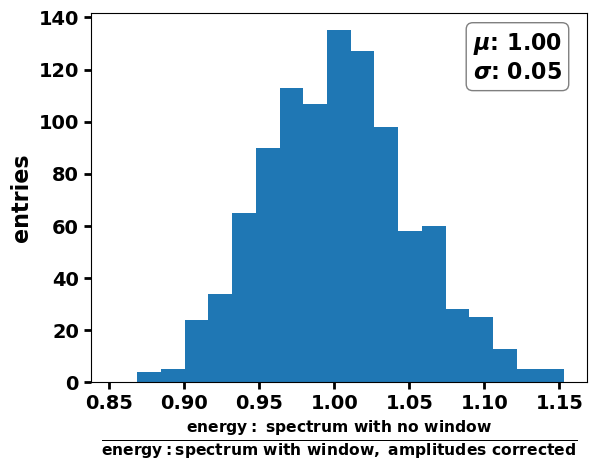

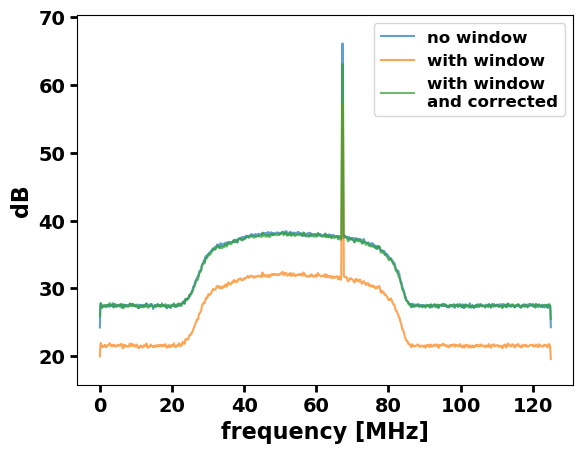

In [26]:
show_results(avr_rspectrum, avr_rspectrum_w, diffs, histo_edge=3)

In [27]:
mock_traces_with_BB_DF = mock_traces_DF.copy(deep=True)
for i in range(mock_traces_with_BB_DF.index.size):
    start_bb_index = np.random.randint(0, 2048-40)
    time_trace = mock_traces_with_BB_DF.iloc[i,2:].values
    time_trace[np.arange(start_bb_index, start_bb_index+40)] = bb_tt[:40]
    mock_traces_with_BB_DF.iloc[i,2:] = time_trace

In [28]:
avr_rspectrum, avr_rspectrum_w, diffs = get_averaged_spectra_and_diffs(mock_traces_with_BB_DF.iloc[:,2:].values)
diffs3 = diffs
label4final_histo.append('mock traces with BB pulse')

7.475733096073659
7.631485984462733


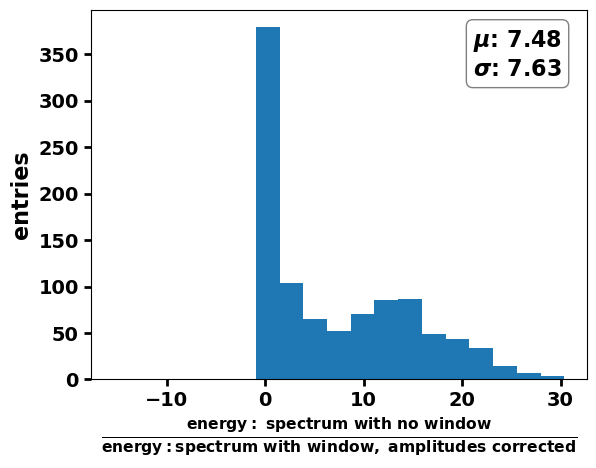

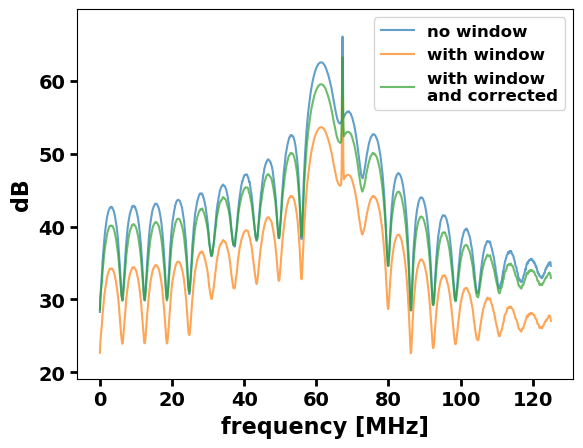

In [29]:
show_results(avr_rspectrum, avr_rspectrum_w, diffs, histo_edge=3)

### Summary

simple traces
Mean and STD:0.0002, 0.0628
Truncated Mean and STD: 0.0002, 0.0628
******
mock traces
Mean and STD:0.0029, 0.0501
Truncated Mean and STD: 0.0029, 0.0501
******
mock traces with BB pulse
Mean and STD:6.4757, 7.6315
Truncated Mean and STD: 6.4757, 7.6315
******


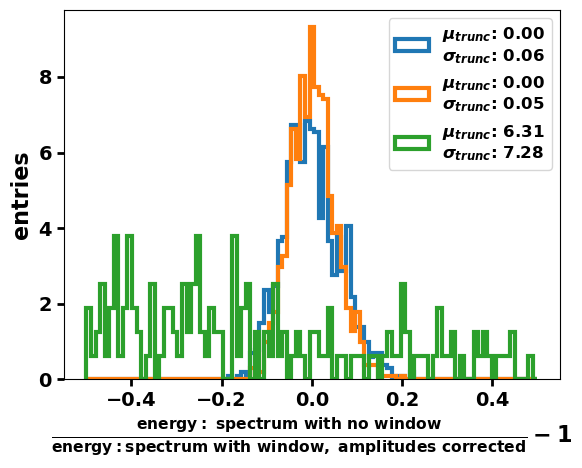

In [30]:
fig, ax = plt.subplots()
fx = np.fft.rfftfreq(N, 1 / fs_Hz) / 1e6

diffs_list = np.asarray([diffs1, diffs2, diffs3], dtype="object") - 1
# diffs_list = [diffs1, diffs2]

bins = np.histogram_bin_edges(np.concatenate(diffs_list), bins=20)


# if bins == None:
bins = linspace_with_middle_value(
    np.mean(np.concatenate(diffs_list)), 2 * np.std(np.concatenate(diffs_list)), 20
)

bins = np.linspace(0.5, 1.5, 100) - 1

for i, diffs in enumerate(diffs_list):
    mean_diff = np.mean(diffs)
    std_diff = np.std(diffs)
    mean_diff_trun, std_diff_trun = calculate_truncated_stats(diffs, 1, 99)
    label = (
        text_box
    ) = f"$\mu_{{trunc}}$: {round(mean_diff_trun,2)+0:.2f}\n$\sigma_{{trunc}}$: {round(std_diff_trun,2)+0:.2f}"
    ax.hist(diffs, bins=bins, alpha=1, density=True, histtype="step", lw=3, label=label)
    # Calculate mean and standard deviation
    print(label4final_histo[i])
    print('Mean and STD:{:.4f}, {:.4f}'.format(mean_diff, std_diff))
    print('Truncated Mean and STD: {:.4f}, {:.4f}'.format(mean_diff, std_diff))
    print("******")

# ax.set_xlim(xax_min, xax_max)
ax.set_xlabel(
    r"$\frac{\mathrm{energy: \ spectrum \ with \ no\ window}}{\mathrm{energy:spectrum \ with\ window,\ amplitudes\ corrected}} -1$"
)
ax.set_ylabel("entries")
ax.legend()

In [31]:
print('The colors corespond to')
print(label4final_histo)
print(', respectively.')

The colors corespond to
['simple traces', 'mock traces', 'mock traces with BB pulse']
, respectively.


CONCLUSION: The broad band pulse in the trace spoils the energy recovery.